In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# 0. Загрузка данных

(1797, 64)


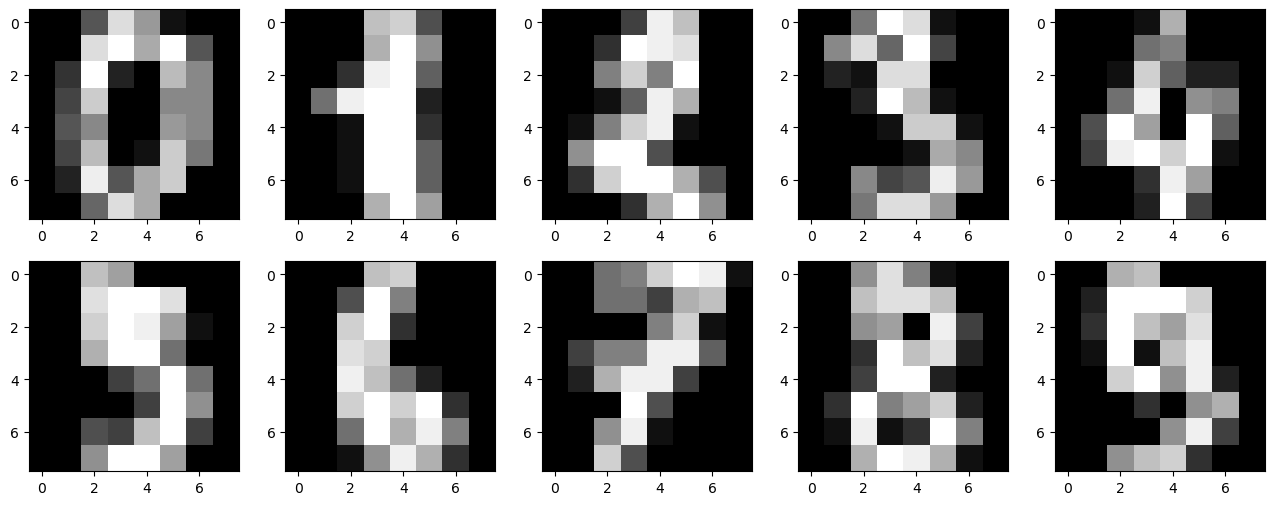

In [2]:
from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler

# Подготовка датасета
X, y = load_digits(return_X_y=True)
print(X.shape)  # 1797 строк (цифр) по 64 столбца (8х8 = 64 пикселя)

# репрезентация данных
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i,:].reshape([8, 8]), cmap='gray')

# 1. Предобработка данных

In [3]:
def to_one_hot(Y):
    # one-hot кодирование обучающих меток
    n_col = np.max(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1
    return binarized

In [4]:
# формирование входных данных
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# формирование выходных данных(результатов)
y = y.flatten()
y = to_one_hot(y)
display(y, y.shape)

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]])

(1797, 10)

In [5]:
X

array([[0.    , 0.    , 0.3125, ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.625 , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 1.    , 0.5625, 0.    ],
       ...,
       [0.    , 0.    , 0.0625, ..., 0.375 , 0.    , 0.    ],
       [0.    , 0.    , 0.125 , ..., 0.75  , 0.    , 0.    ],
       [0.    , 0.    , 0.625 , ..., 0.75  , 0.0625, 0.    ]])

# 2. Базовое решение 

In [6]:
# датафрейм для сохранения статистики

stata = pd.DataFrame(columns=['model_name',             # название решения
                              'neuron_num',             # количество нейронов скрытого слоя
                              'learning_rate',          # learning rate
                              'num_epochs',             # количество эпох обучения
                              'accuracy_train',         # точность на тренировочных данных
                              'accuracy_test']          # точность на тестовых данных
                              )

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.shape, X_test.shape

((1203, 64), (594, 64))

In [8]:
# сигмоида
def sigmoid(x):
    x = np.clip(x, a_min=-500, a_max=500)
    return 1 / (1 + np.exp(-x))

# производная сигмоиды
def sigmoid_deriv(x):
    return sigmoid(x) * (1 - sigmoid(x))

In [9]:
def plot_errors_acc(model_errors, metrics, title=''):
    ''' Функция вывода графиков ошибки и точности обучения НС '''

    fig = plt.figure(figsize=(16, 7), dpi=300)
    fig.suptitle(title, fontsize=14)
    plt.subplot(2, 1, 1)
    plt.plot(model_errors)
    plt.xlabel('Итерация обучения')
    plt.ylabel('Ошибка')
            
    plt.subplot(2, 1, 2)
    plt.plot(metrics)
    plt.xlabel('Итерация обучения')
    plt.ylabel('Точность на обучении')
       
    plt.tight_layout()

    

In [10]:
def nn_fit(X, y, neuron_num=5, learning_rate=0.1, num_epochs=100):

    ''' Функция обучения нейронной сети, подсчета ошибки и точности обучения '''

    # случайная инициализация весов
    np.random.seed(1)
    w0 = np.random.random((64, neuron_num))  # для входного слоя    - 64 входа, neuron_numb выходов
    w1 = np.random.random((neuron_num, 10))  # для внутреннего слоя - neuron_numb входов, 10 выходов

    errors = []
    metrics = []

    # процесс обучения
    for _ in range(num_epochs):

        # прямое распространение(feed forward)
        layer0 = X                                # вход
        layer1 = sigmoid(np.dot(layer0, w0))            # промежуточный слой
        layer2 = sigmoid(np.dot(layer1, w1))            # выход

        # обратное распространение (back propagation)
        # с использованием градиентного спуска
        layer2_error = layer2 - y_train  # производная функции потерь
        layer2_grad = layer2_error * sigmoid_deriv(layer2)

        layer1_error = layer2_grad.dot(w1.T)
        layer1_grad = layer1_error * sigmoid_deriv(layer1)

        w1 -= layer1.T.dot(layer2_grad) * learning_rate         # веса на вых. слой
        w0 -= layer0.T.dot(layer1_grad) * learning_rate         # веса на скрытый слой

        # ошибка модели
        error = np.mean(np.abs(layer2_error))
        errors.append(error)

        # метрики качества
        preds = np.argmax(layer2, axis=1)
        labels = np.argmax(y, axis=1)
        accuracy = (preds == labels).sum() * 100 / len(labels)
        metrics.append(accuracy)

    return {
        'weights': (w0, w1),
        'errors': errors,
        'accuracy_train': metrics,
        'neuron_num': neuron_num,
        'learning_rate': learning_rate,
        'num_epochs': num_epochs,
    }



In [11]:
# обучение нн и подсчет точности на трейне

params_nn = nn_fit(X_train, y_train)
weights = params_nn['weights']
metrics = {}
metrics['train'] = params_nn['accuracy_train'][-1]

In [12]:
# обучение нн и подсчет точности на тесте
layer0_test = X_test
layer1_test = sigmoid(np.dot(layer0_test, weights[0]))
layer2_test = sigmoid(np.dot(layer1_test, weights[1]))

preds_test = np.argmax(layer2_test, axis=1)
labels_test = np.argmax(y_test, axis=1)
metrics['test'] = (preds_test == labels_test).sum() * 100 / len(labels_test)

In [13]:
stata = stata.append({
        'model_name': 'BaseLine',
        'neuron_num': params_nn['neuron_num'],
        'learning_rate': params_nn['learning_rate'],
        'num_epochs': params_nn['num_epochs'],
        'accuracy_train': metrics['train'],
        'accuracy_test': metrics['test'],
    }, ignore_index=True)
stata

,model_name,neuron_num,learning_rate,num_epochs,accuracy_train,accuracy_test
0,BaseLine,5,0.1,100,47.630923,42.760943


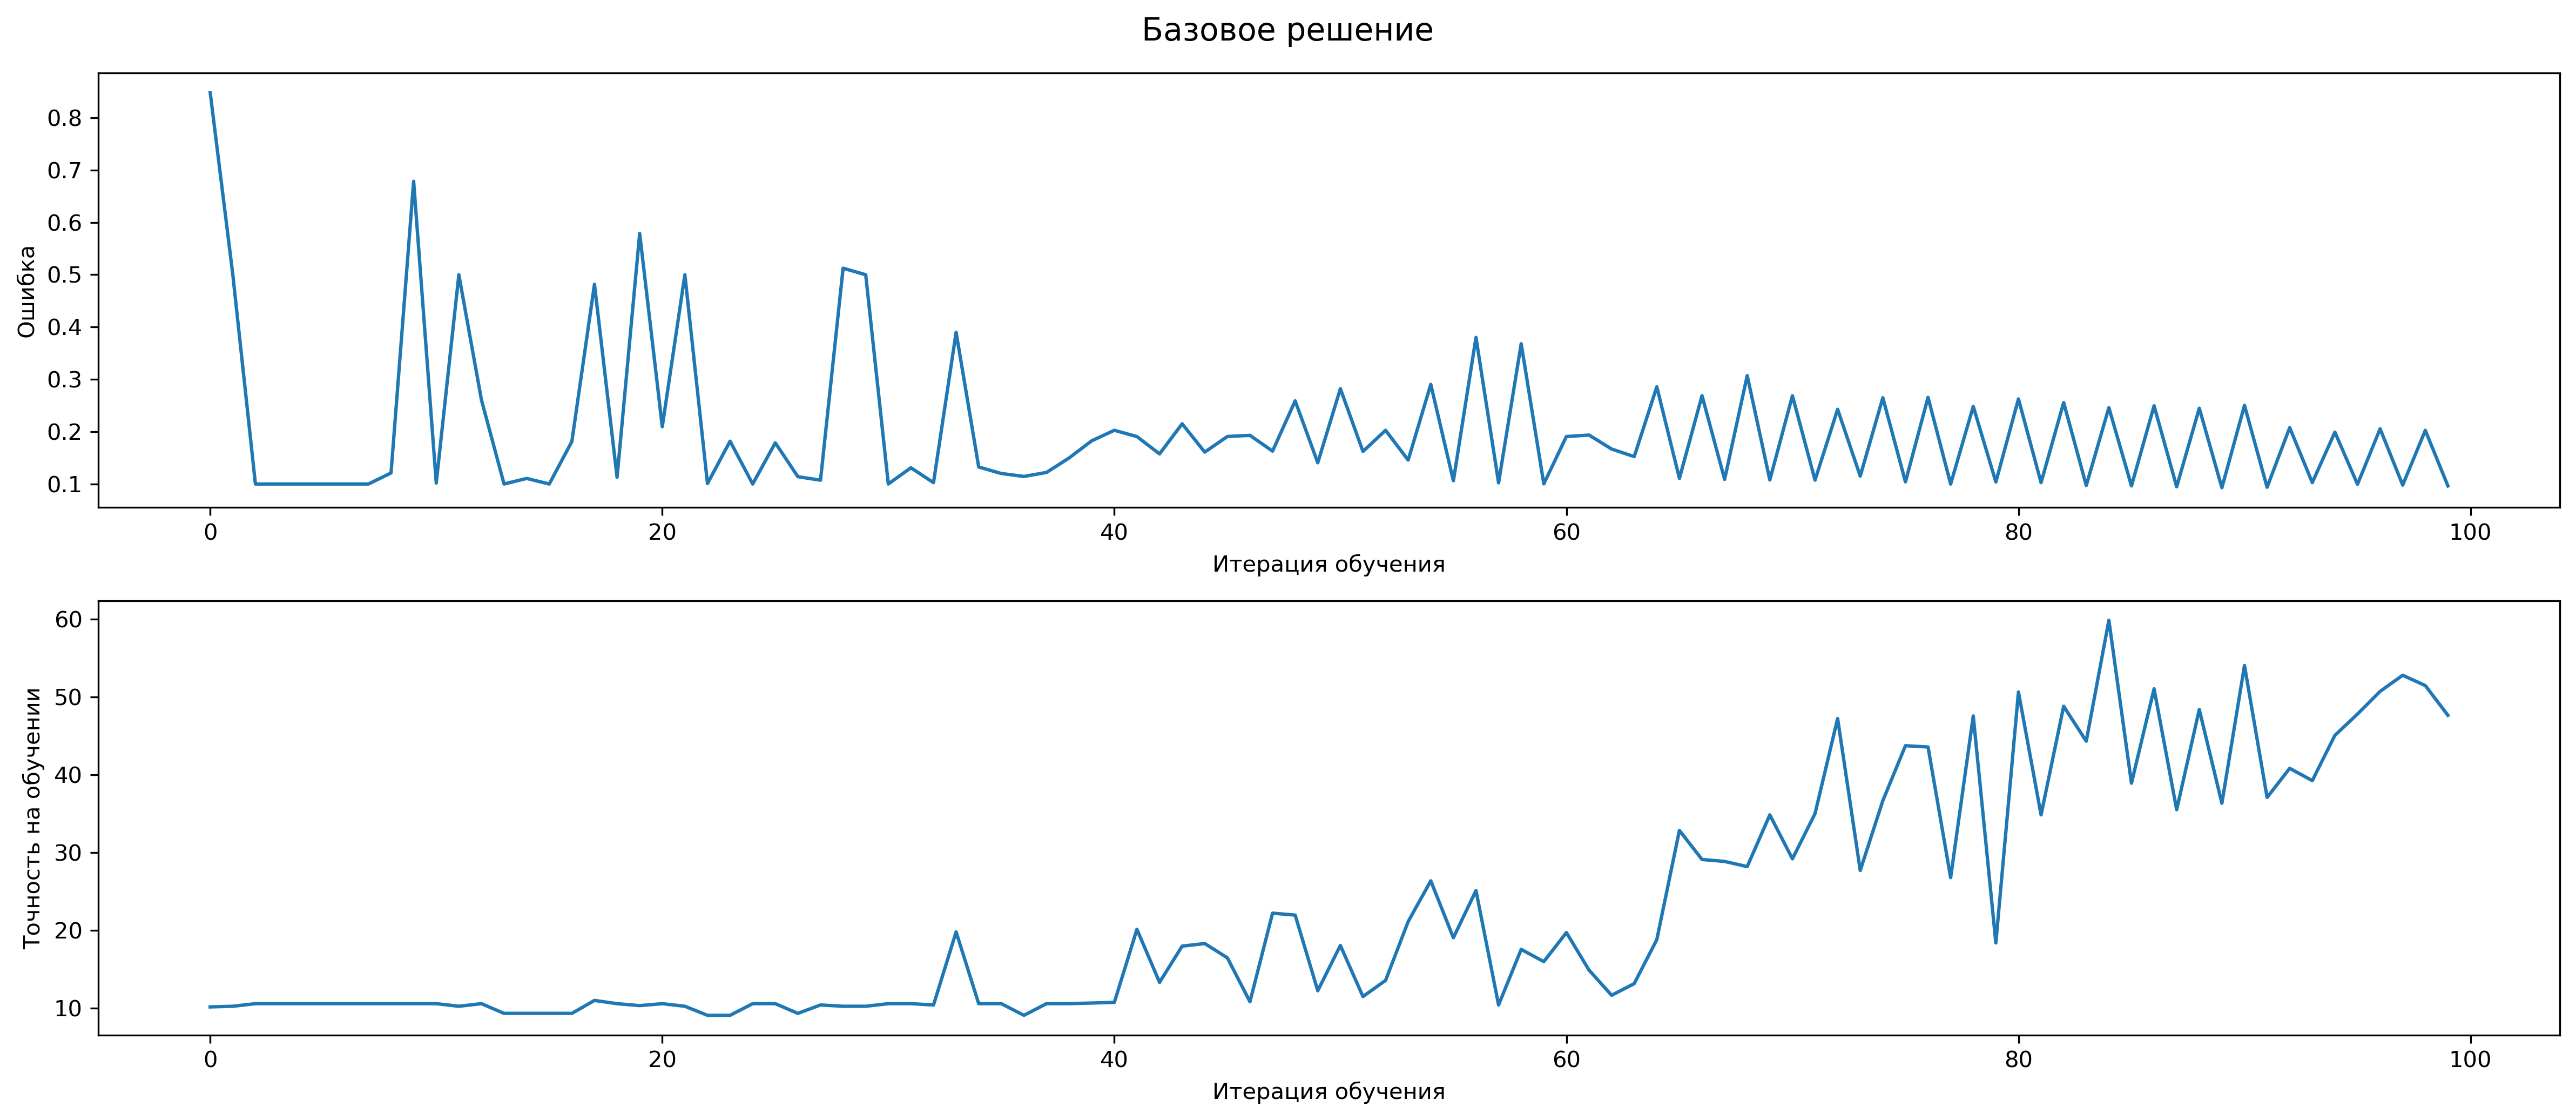

In [14]:
plot_errors_acc(params_nn['errors'], params_nn['accuracy_train'], "Базовое решение")

# 3. Улучшение качества базового решения

## 3.1 Меняем количество весов в скрытом слое

In [15]:
%%time

for nn in [10, 15, 30, 50, 60, 75, 90, 100]:
    params_nn = nn_fit(X_train, y_train, neuron_num=nn)
    weights = params_nn['weights']
    metrics = {}
    metrics['train'] = params_nn['accuracy_train'][-1]
    
    # тест
    layer0_test = X_test
    layer1_test = sigmoid(np.dot(layer0_test, weights[0]))
    layer2_test = sigmoid(np.dot(layer1_test, weights[1]))

    preds_test = np.argmax(layer2_test, axis=1)
    labels_test = np.argmax(y_test, axis=1)
    metrics['test'] = (preds_test == labels_test).sum() * 100 / len(labels_test)

    
    stata = stata.append({
        'model_name': f'Perceptron_with_{nn}_hidden_neurons',
        'neuron_num': params_nn['neuron_num'],
        'learning_rate': params_nn['learning_rate'],
        'num_epochs': params_nn['num_epochs'],
        'accuracy_train': metrics['train'],
        'accuracy_test': metrics['test'],
    }, ignore_index=True)

stata

CPU times: user 5.79 s, sys: 139 ms, total: 5.93 s
Wall time: 4.09 s


,model_name,neuron_num,learning_rate,num_epochs,accuracy_train,accuracy_test
0,BaseLine,5,0.1,100,47.630923,42.760943
1,Perceptron_with_10_hidden_neurons,10,0.1,100,59.185370,56.228956
2,Perceptron_with_15_hidden_neurons,15,0.1,100,70.822943,71.380471
3,Perceptron_with_30_hidden_neurons,30,0.1,100,89.027431,85.521886
4,Perceptron_with_50_hidden_neurons,50,0.1,100,84.039900,80.134680
5,Perceptron_with_60_hidden_neurons,60,0.1,100,81.296758,82.154882
6,Perceptron_with_75_hidden_neurons,75,0.1,100,86.783042,86.868687
7,Perceptron_with_90_hidden_neurons,90,0.1,100,83.956775,82.154882
8,Perceptron_with_100_hidden_neurons,100,0.1,100,78.221114,75.589226


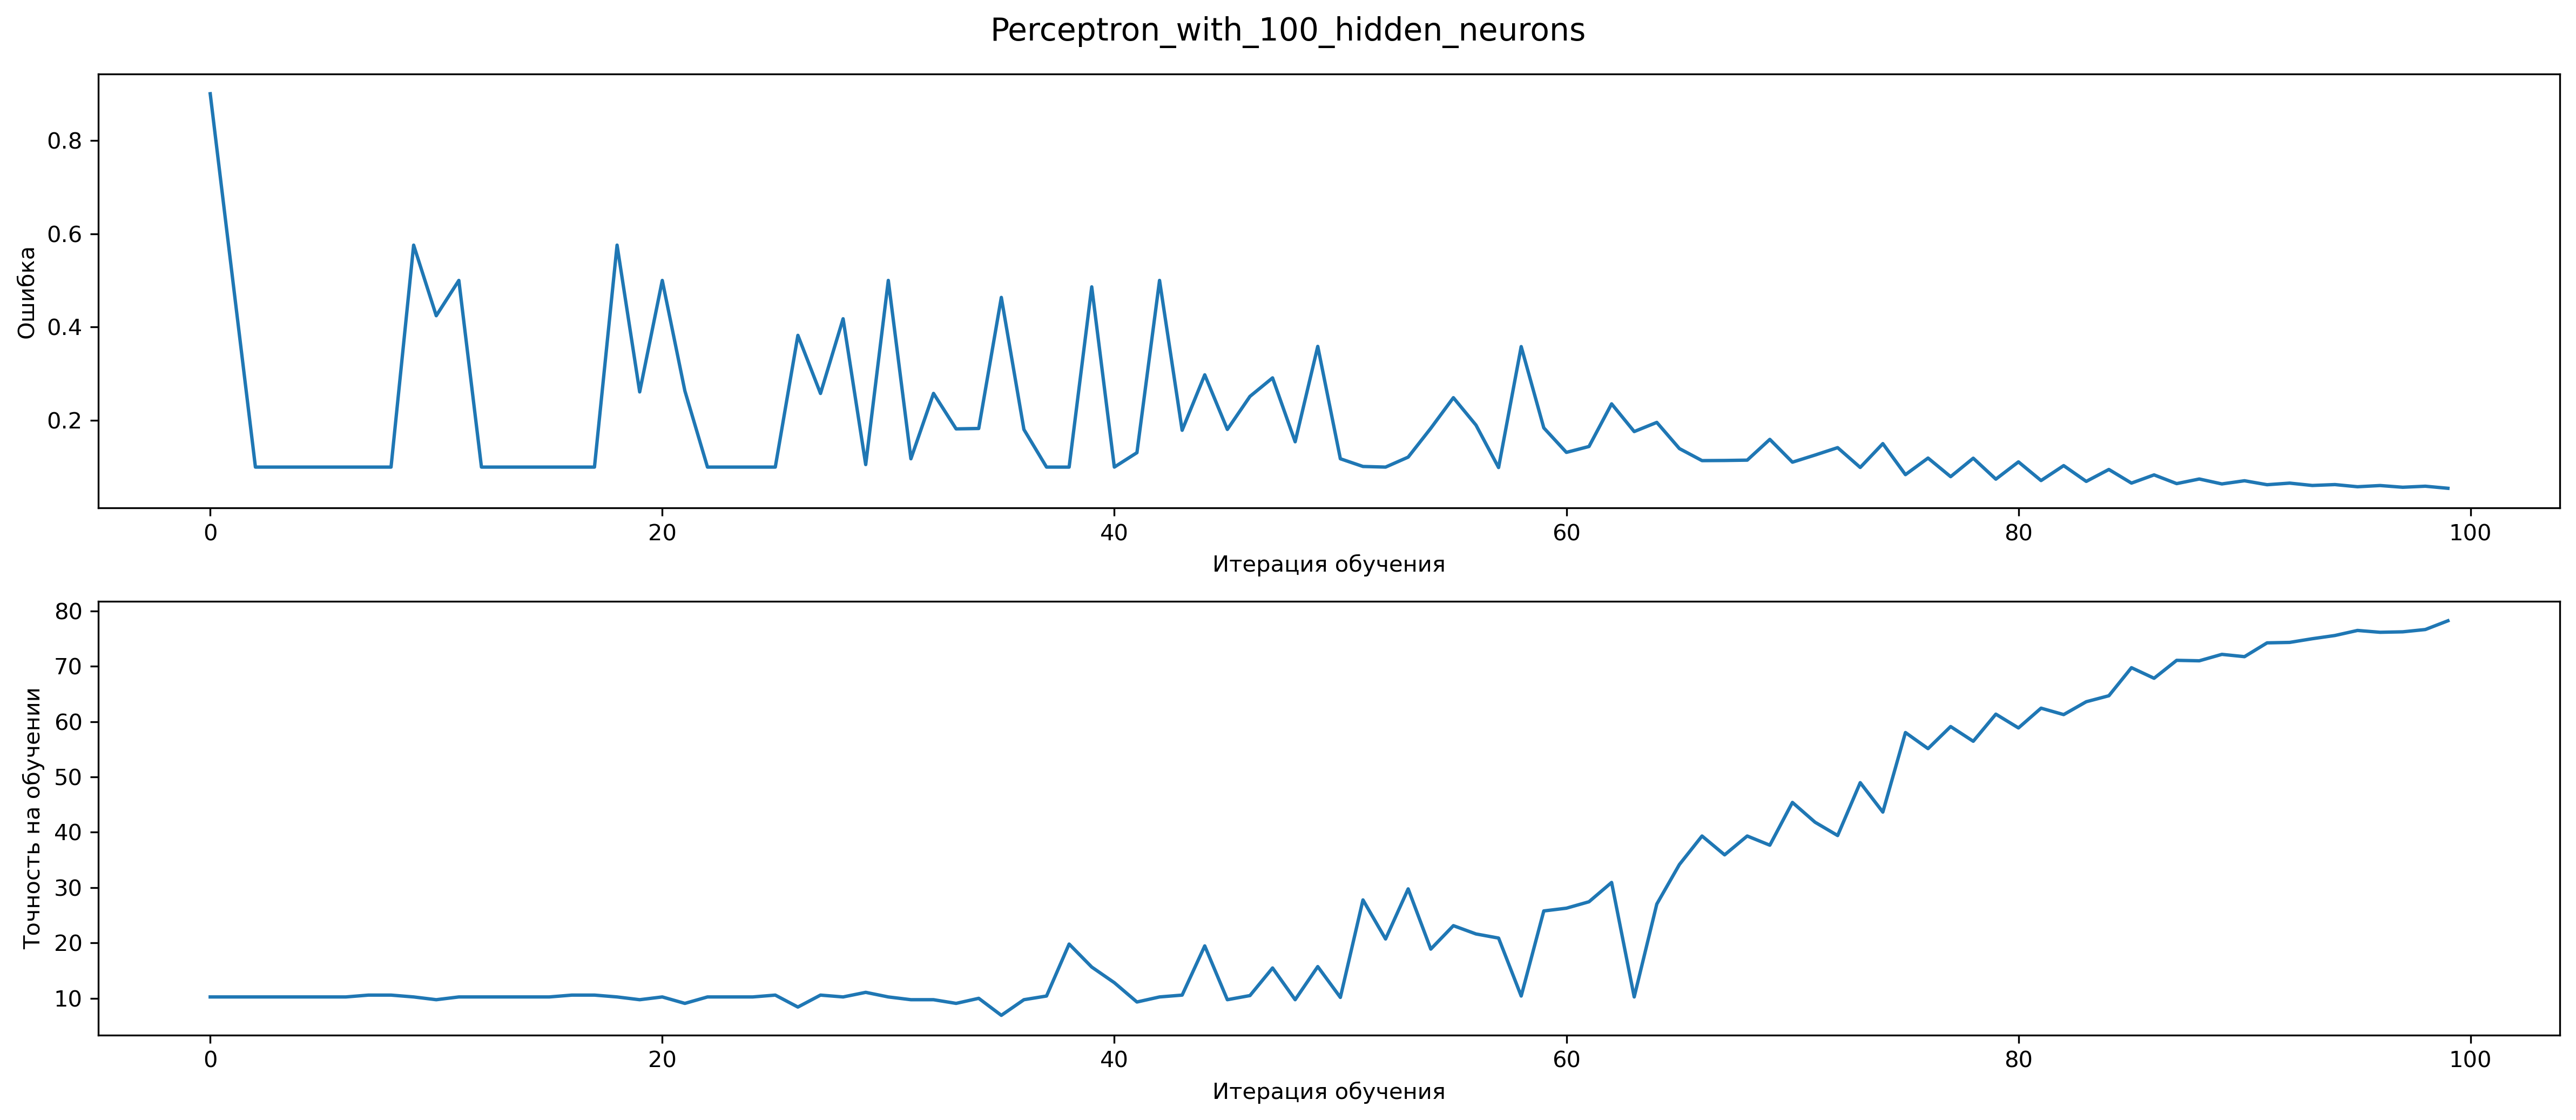

In [16]:
plot_errors_acc(params_nn['errors'], params_nn['accuracy_train'], f'Perceptron_with_{nn}_hidden_neurons')

## 3.2 Меняем learning_rate

In [17]:
%%time

for lr in [1, 0.8, 0.65, 0.5, 0.25, 0.15, .05, .01, .005, .001, .0005]:
    params_nn = nn_fit(X_train, y_train, learning_rate=lr)
    weights = params_nn['weights']
    metrics = {}
    metrics['train'] = params_nn['accuracy_train'][-1]
    
    # тест
    layer0_test = X_test
    layer1_test = sigmoid(np.dot(layer0_test, weights[0]))
    layer2_test = sigmoid(np.dot(layer1_test, weights[1]))

    preds_test = np.argmax(layer2_test, axis=1)
    labels_test = np.argmax(y_test, axis=1)
    metrics['test'] = (preds_test == labels_test).sum() * 100 / len(labels_test)

    
    stata = stata.append({
        'model_name': f'Perceptron_with_{lr}_learning_rate',
        'neuron_num': params_nn['neuron_num'],
        'learning_rate': params_nn['learning_rate'],
        'num_epochs': params_nn['num_epochs'],
        'accuracy_train': metrics['train'],
        'accuracy_test': metrics['test'],
    }, ignore_index=True)

stata

CPU times: user 2.84 s, sys: 91 ms, total: 2.93 s
Wall time: 2.02 s


,model_name,neuron_num,learning_rate,num_epochs,accuracy_train,accuracy_test
0,BaseLine,5,0.1000,100,47.630923,42.760943
1,Perceptron_with_10_hidden_neurons,10,0.1000,100,59.185370,56.228956
2,Perceptron_with_15_hidden_neurons,15,0.1000,100,70.822943,71.380471
3,Perceptron_with_30_hidden_neurons,30,0.1000,100,89.027431,85.521886
4,Perceptron_with_50_hidden_neurons,50,0.1000,100,84.039900,80.134680
5,Perceptron_with_60_hidden_neurons,60,0.1000,100,81.296758,82.154882
6,Perceptron_with_75_hidden_neurons,75,0.1000,100,86.783042,86.868687
7,Perceptron_with_90_hidden_neurons,90,0.1000,100,83.956775,82.154882
8,Perceptron_with_100_hidden_neurons,100,0.1000,100,78.221114,75.589226
9,Perceptron_with_1_learning_rate,5,1.0000,100,30.673317,13.468013


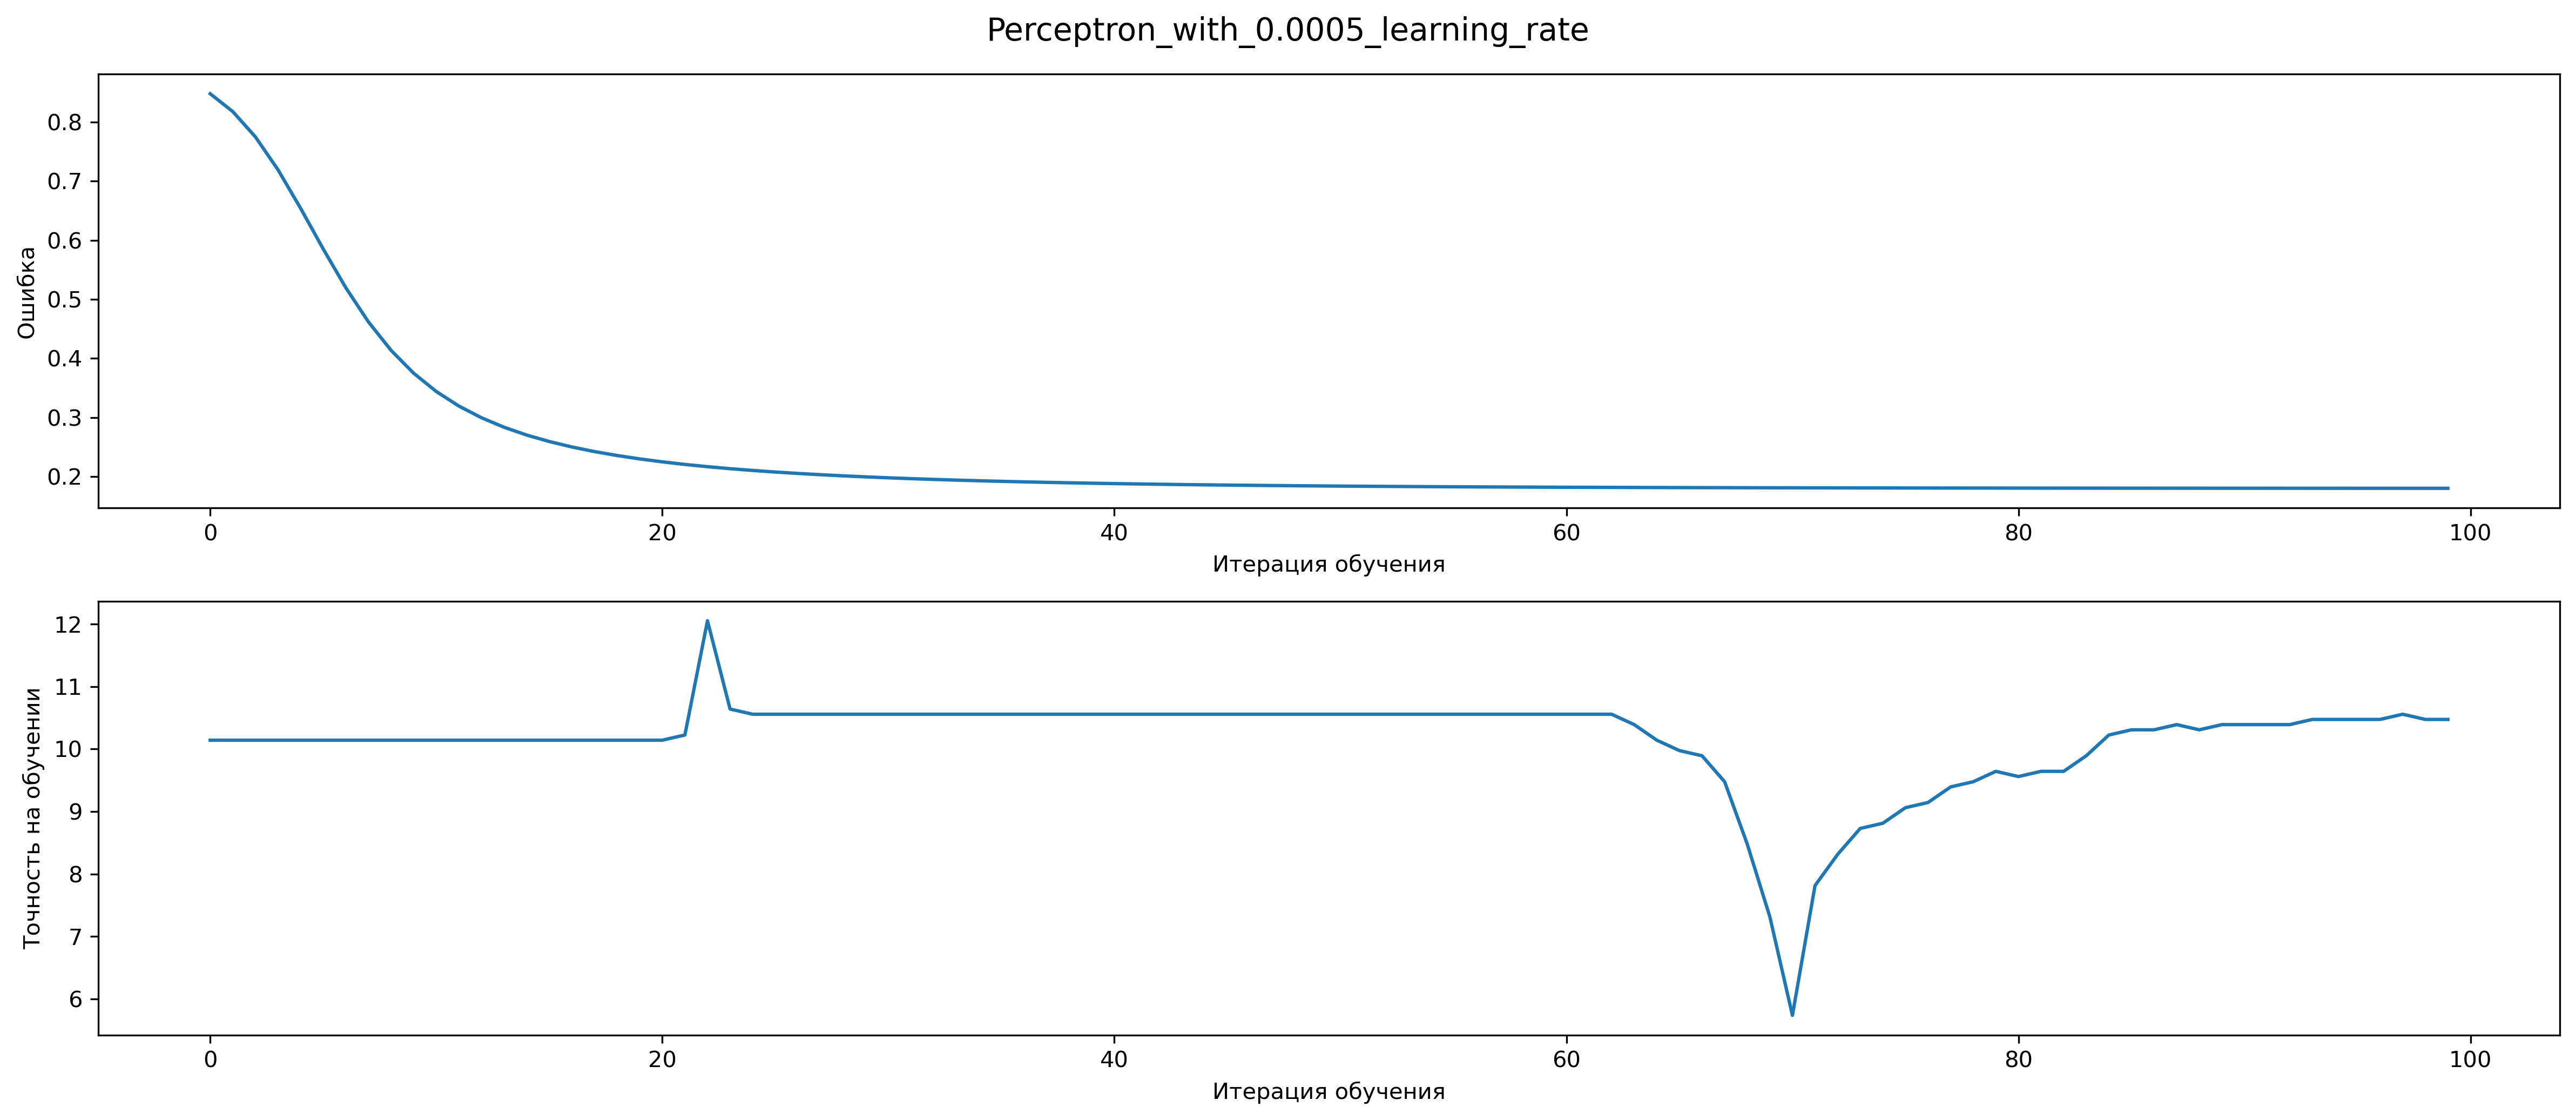

In [18]:
plot_errors_acc(params_nn['errors'], params_nn['accuracy_train'], f'Perceptron_with_{lr}_learning_rate')

## 3.3 Динамически меняем learning_rate

In [19]:
def nn_fit_dynamic_lr(X, y, neuron_num=5, num_epochs=100):

    ''' Функция обучения нейронной сети и вывода ошибки обучения '''

    # случайная инициализация весов
    np.random.seed(1)
    w0 = np.random.random((64, neuron_num))  # для входного слоя    - 64 входа, neuron_numb выходов
    w1 = np.random.random((neuron_num, 10))  # для внутреннего слоя - neuron_numb входов, 10 выходов

    errors = []
    metrics = []

    # процесс обучения
    for i in range(num_epochs):

        learning_rate = 1 / np.sqrt(i+1)

        # прямое распространение(feed forward)
        layer0 = X                                # вход
        layer1 = sigmoid(np.dot(layer0, w0))            # промежуточный слой
        layer2 = sigmoid(np.dot(layer1, w1))            # выход

        # обратное распространение (back propagation)
        # с использованием градиентного спуска
        layer2_error = layer2 - y_train  # производная функции потерь
        layer2_grad = layer2_error * sigmoid_deriv(layer2)

        layer1_error = layer2_grad.dot(w1.T)
        layer1_grad = layer1_error * sigmoid_deriv(layer1)

        w1 -= layer1.T.dot(layer2_grad) * learning_rate         # веса на вых. слой
        w0 -= layer0.T.dot(layer1_grad) * learning_rate         # веса на скрытый слой

        # ошибка модели
        error = np.mean(np.abs(layer2_error))
        errors.append(error)

        # метрики качества
        preds = np.argmax(layer2, axis=1)
        labels = np.argmax(y, axis=1)
        accuracy = (preds == labels).sum() * 100 / len(labels)
        metrics.append(accuracy)

    return {
        'weights': (w0, w1),
        'errors': errors,
        'accuracy_train': metrics,
        'neuron_num': neuron_num,
        'learning_rate': learning_rate,
        'num_epochs': num_epochs,
    }



In [20]:
%%time

params_nn = nn_fit_dynamic_lr(X_train, y_train)
weights = params_nn['weights']
metrics = {}
metrics['train'] = params_nn['accuracy_train'][-1]
    
# тест
layer0_test = X_test
layer1_test = sigmoid(np.dot(layer0_test, weights[0]))
layer2_test = sigmoid(np.dot(layer1_test, weights[1]))

preds_test = np.argmax(layer2_test, axis=1)
labels_test = np.argmax(y_test, axis=1)
metrics['test'] = (preds_test == labels_test).sum() * 100 / len(labels_test)

    
stata = stata.append({
    'model_name': f'Perceptron_with_dynamic_learning_rate',
    'neuron_num': params_nn['neuron_num'],
    'learning_rate': params_nn['learning_rate'],
    'num_epochs': params_nn['num_epochs'],
    'accuracy_train': metrics['train'],
    'accuracy_test': metrics['test'],
}, ignore_index=True)

stata

CPU times: user 256 ms, sys: 16.7 ms, total: 273 ms
Wall time: 279 ms


,model_name,neuron_num,learning_rate,num_epochs,accuracy_train,accuracy_test
0,BaseLine,5,0.1000,100,47.630923,42.760943
1,Perceptron_with_10_hidden_neurons,10,0.1000,100,59.185370,56.228956
2,Perceptron_with_15_hidden_neurons,15,0.1000,100,70.822943,71.380471
3,Perceptron_with_30_hidden_neurons,30,0.1000,100,89.027431,85.521886
4,Perceptron_with_50_hidden_neurons,50,0.1000,100,84.039900,80.134680
5,Perceptron_with_60_hidden_neurons,60,0.1000,100,81.296758,82.154882
6,Perceptron_with_75_hidden_neurons,75,0.1000,100,86.783042,86.868687
7,Perceptron_with_90_hidden_neurons,90,0.1000,100,83.956775,82.154882
8,Perceptron_with_100_hidden_neurons,100,0.1000,100,78.221114,75.589226
9,Perceptron_with_1_learning_rate,5,1.0000,100,30.673317,13.468013


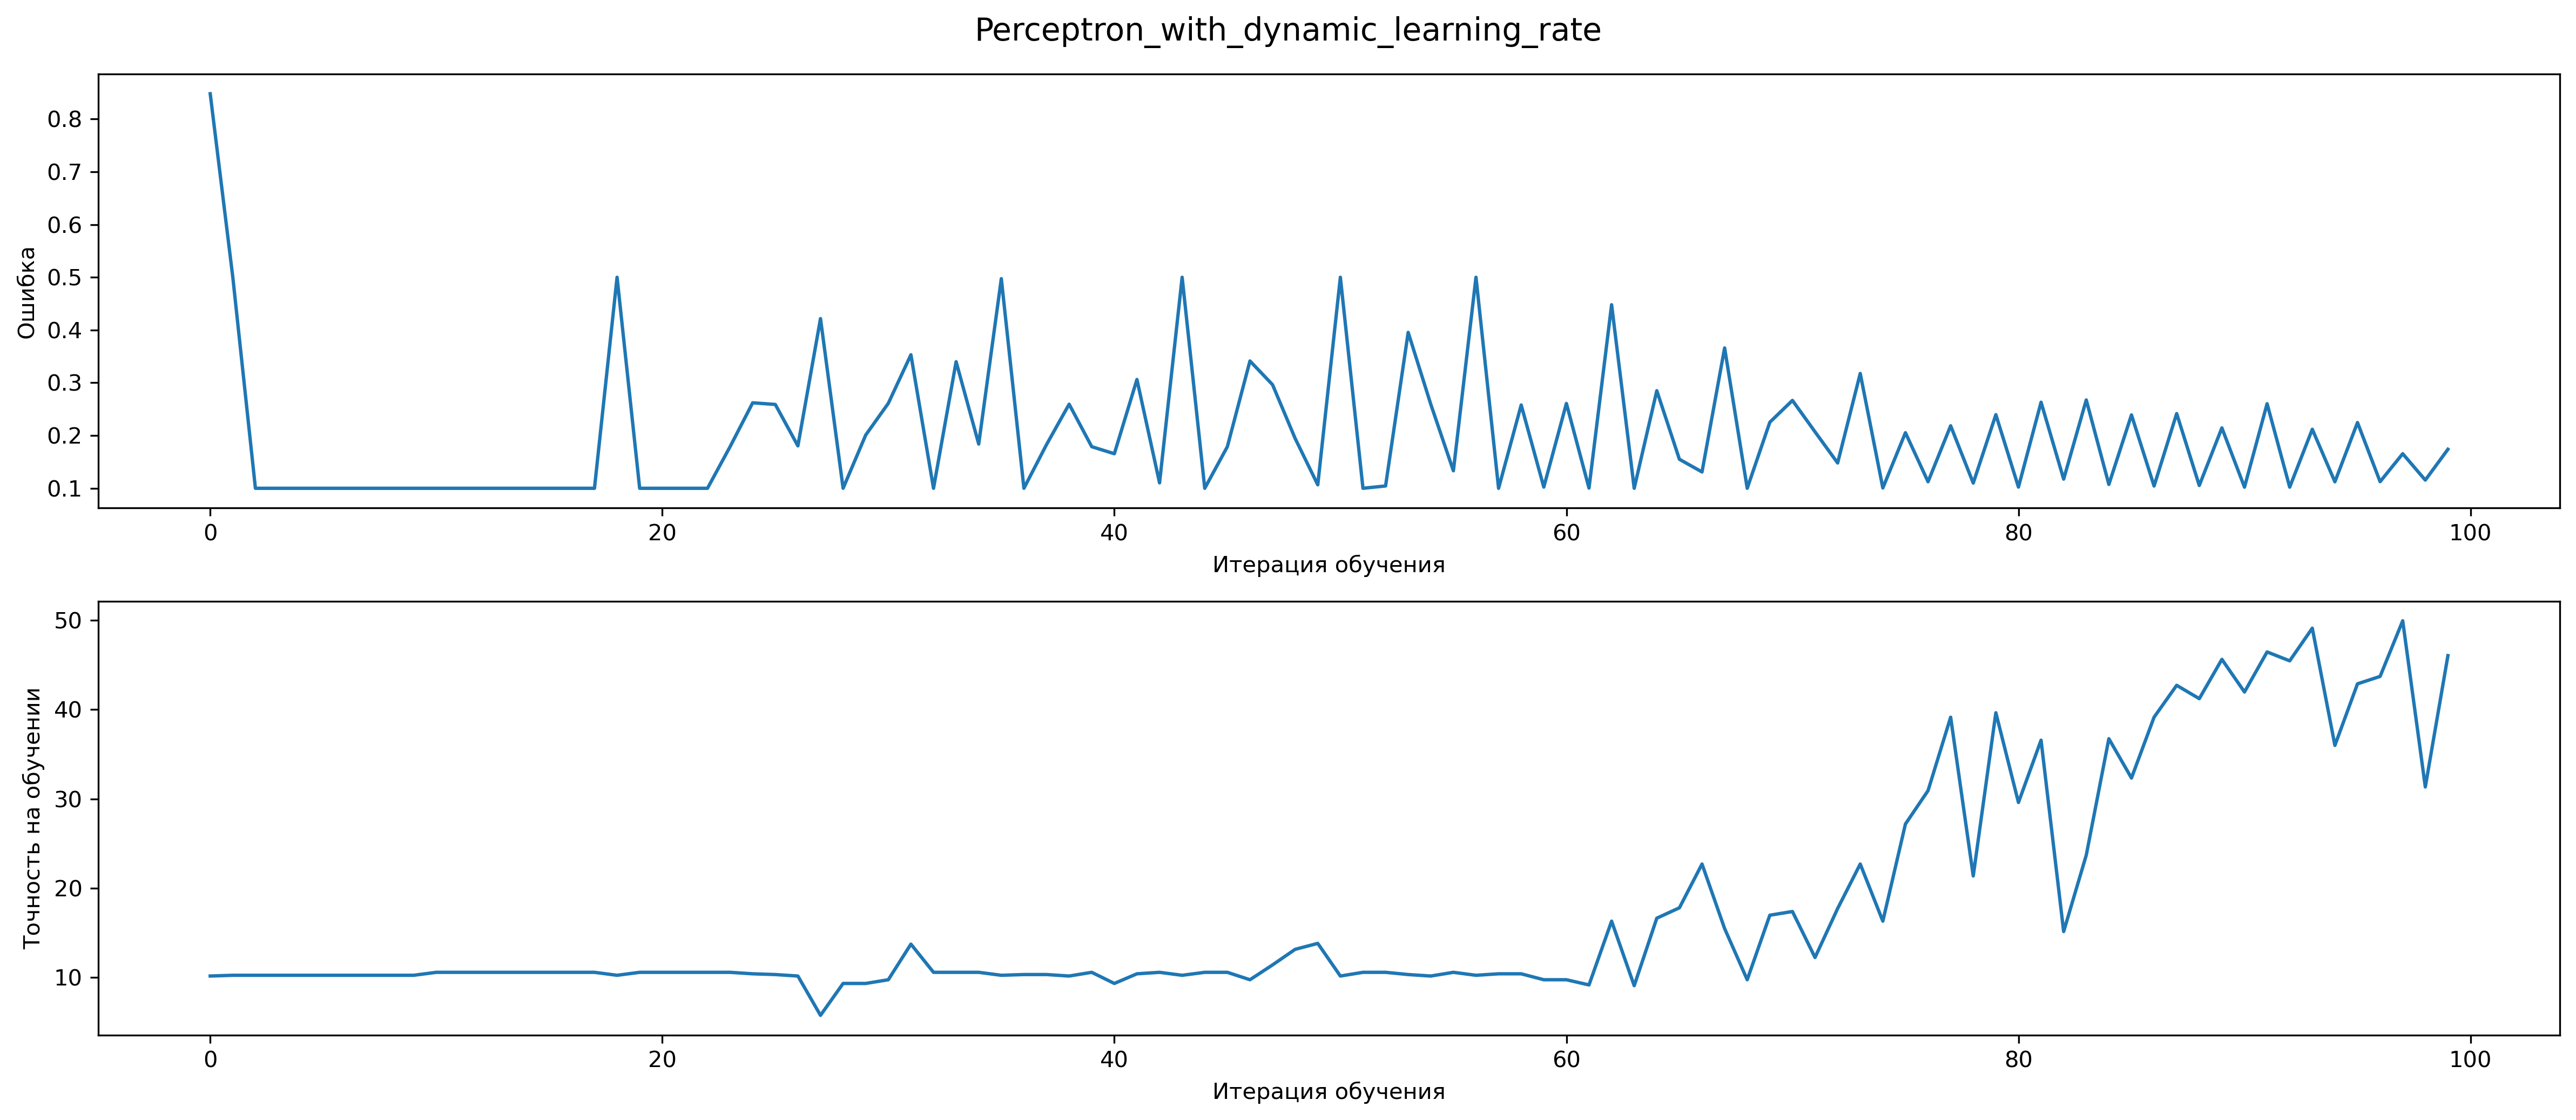

In [21]:
plot_errors_acc(params_nn['errors'], params_nn['accuracy_train'], 'Perceptron_with_dynamic_learning_rate')

## 3.4 Меняем функциию активации на softmax

In [22]:
from scipy.special import softmax

def softmax_deriv(x):
    return softmax(x, axis=1) * (1 - softmax(x, axis=1))

In [23]:
def nn_softmax_fit(X, y, neuron_num=5, learning_rate=0.1, num_epochs=100):

    ''' Функция обучения нейронной сети с функцией активации softmax и вывода ошибки обучения '''

    # случайная инициализация весов
    np.random.seed(1)
    w0 = np.random.random((64, neuron_num))  # для входного слоя    - 64 входа, neuron_numb выходов
    w1 = np.random.random((neuron_num, 10))  # для внутреннего слоя - neuron_numb входов, 10 выходов

    errors = []
    metrics = []

    # процесс обучения
    for _ in range(num_epochs):

        # прямое распространение(feed forward)
        layer0 = X                                # вход
        layer1 = softmax(np.dot(layer0, w0), axis=1)            # промежуточный слой
        layer2 = softmax(np.dot(layer1, w1), axis=1)            # выход

        # обратное распространение (back propagation)
        # с использованием градиентного спуска
        layer2_error = layer2 - y_train  # производная функции потерь
        layer2_grad = layer2_error * softmax_deriv(layer2)

        layer1_error = layer2_grad.dot(w1.T)
        layer1_grad = layer1_error * softmax_deriv(layer1)

        w1 -= layer1.T.dot(layer2_grad) * learning_rate         # веса на вых. слой
        w0 -= layer0.T.dot(layer1_grad) * learning_rate         # веса на скрытый слой

        # ошибка модели
        error = np.mean(np.abs(layer2_error))
        errors.append(error)

        # метрики качества
        preds = np.argmax(layer2, axis=1)
        labels = np.argmax(y, axis=1)
        accuracy = (preds == labels).sum() * 100 / len(labels)
        metrics.append(accuracy)

    return {
        'weights': (w0, w1),
        'errors': errors,
        'accuracy_train': metrics,
        'neuron_num': neuron_num,
        'learning_rate': learning_rate,
        'num_epochs': num_epochs,
    }

In [24]:
params_nn = nn_softmax_fit(X_train, y_train)
weights = params_nn['weights']
metrics = {}
metrics['train'] = params_nn['accuracy_train'][-1]
    
# тест
layer0_test = X_test
layer1_test = softmax(np.dot(layer0_test, weights[0]), axis=1)
layer2_test = softmax(np.dot(layer1_test, weights[1]), axis=1)

preds_test = np.argmax(layer2_test, axis=1)
labels_test = np.argmax(y_test, axis=1)
metrics['test'] = (preds_test == labels_test).sum() * 100 / len(labels_test)

    
stata = stata.append({
    'model_name': f'Perceptron_with_softmax',
    'neuron_num': params_nn['neuron_num'],
    'learning_rate': params_nn['learning_rate'],
    'num_epochs': params_nn['num_epochs'],
    'accuracy_train': metrics['train'],
    'accuracy_test': metrics['test'],
}, ignore_index=True)

stata

,model_name,neuron_num,learning_rate,num_epochs,accuracy_train,accuracy_test
0,BaseLine,5,0.1000,100,47.630923,42.760943
1,Perceptron_with_10_hidden_neurons,10,0.1000,100,59.185370,56.228956
2,Perceptron_with_15_hidden_neurons,15,0.1000,100,70.822943,71.380471
3,Perceptron_with_30_hidden_neurons,30,0.1000,100,89.027431,85.521886
4,Perceptron_with_50_hidden_neurons,50,0.1000,100,84.039900,80.134680
5,Perceptron_with_60_hidden_neurons,60,0.1000,100,81.296758,82.154882
6,Perceptron_with_75_hidden_neurons,75,0.1000,100,86.783042,86.868687
7,Perceptron_with_90_hidden_neurons,90,0.1000,100,83.956775,82.154882
8,Perceptron_with_100_hidden_neurons,100,0.1000,100,78.221114,75.589226
9,Perceptron_with_1_learning_rate,5,1.0000,100,30.673317,13.468013


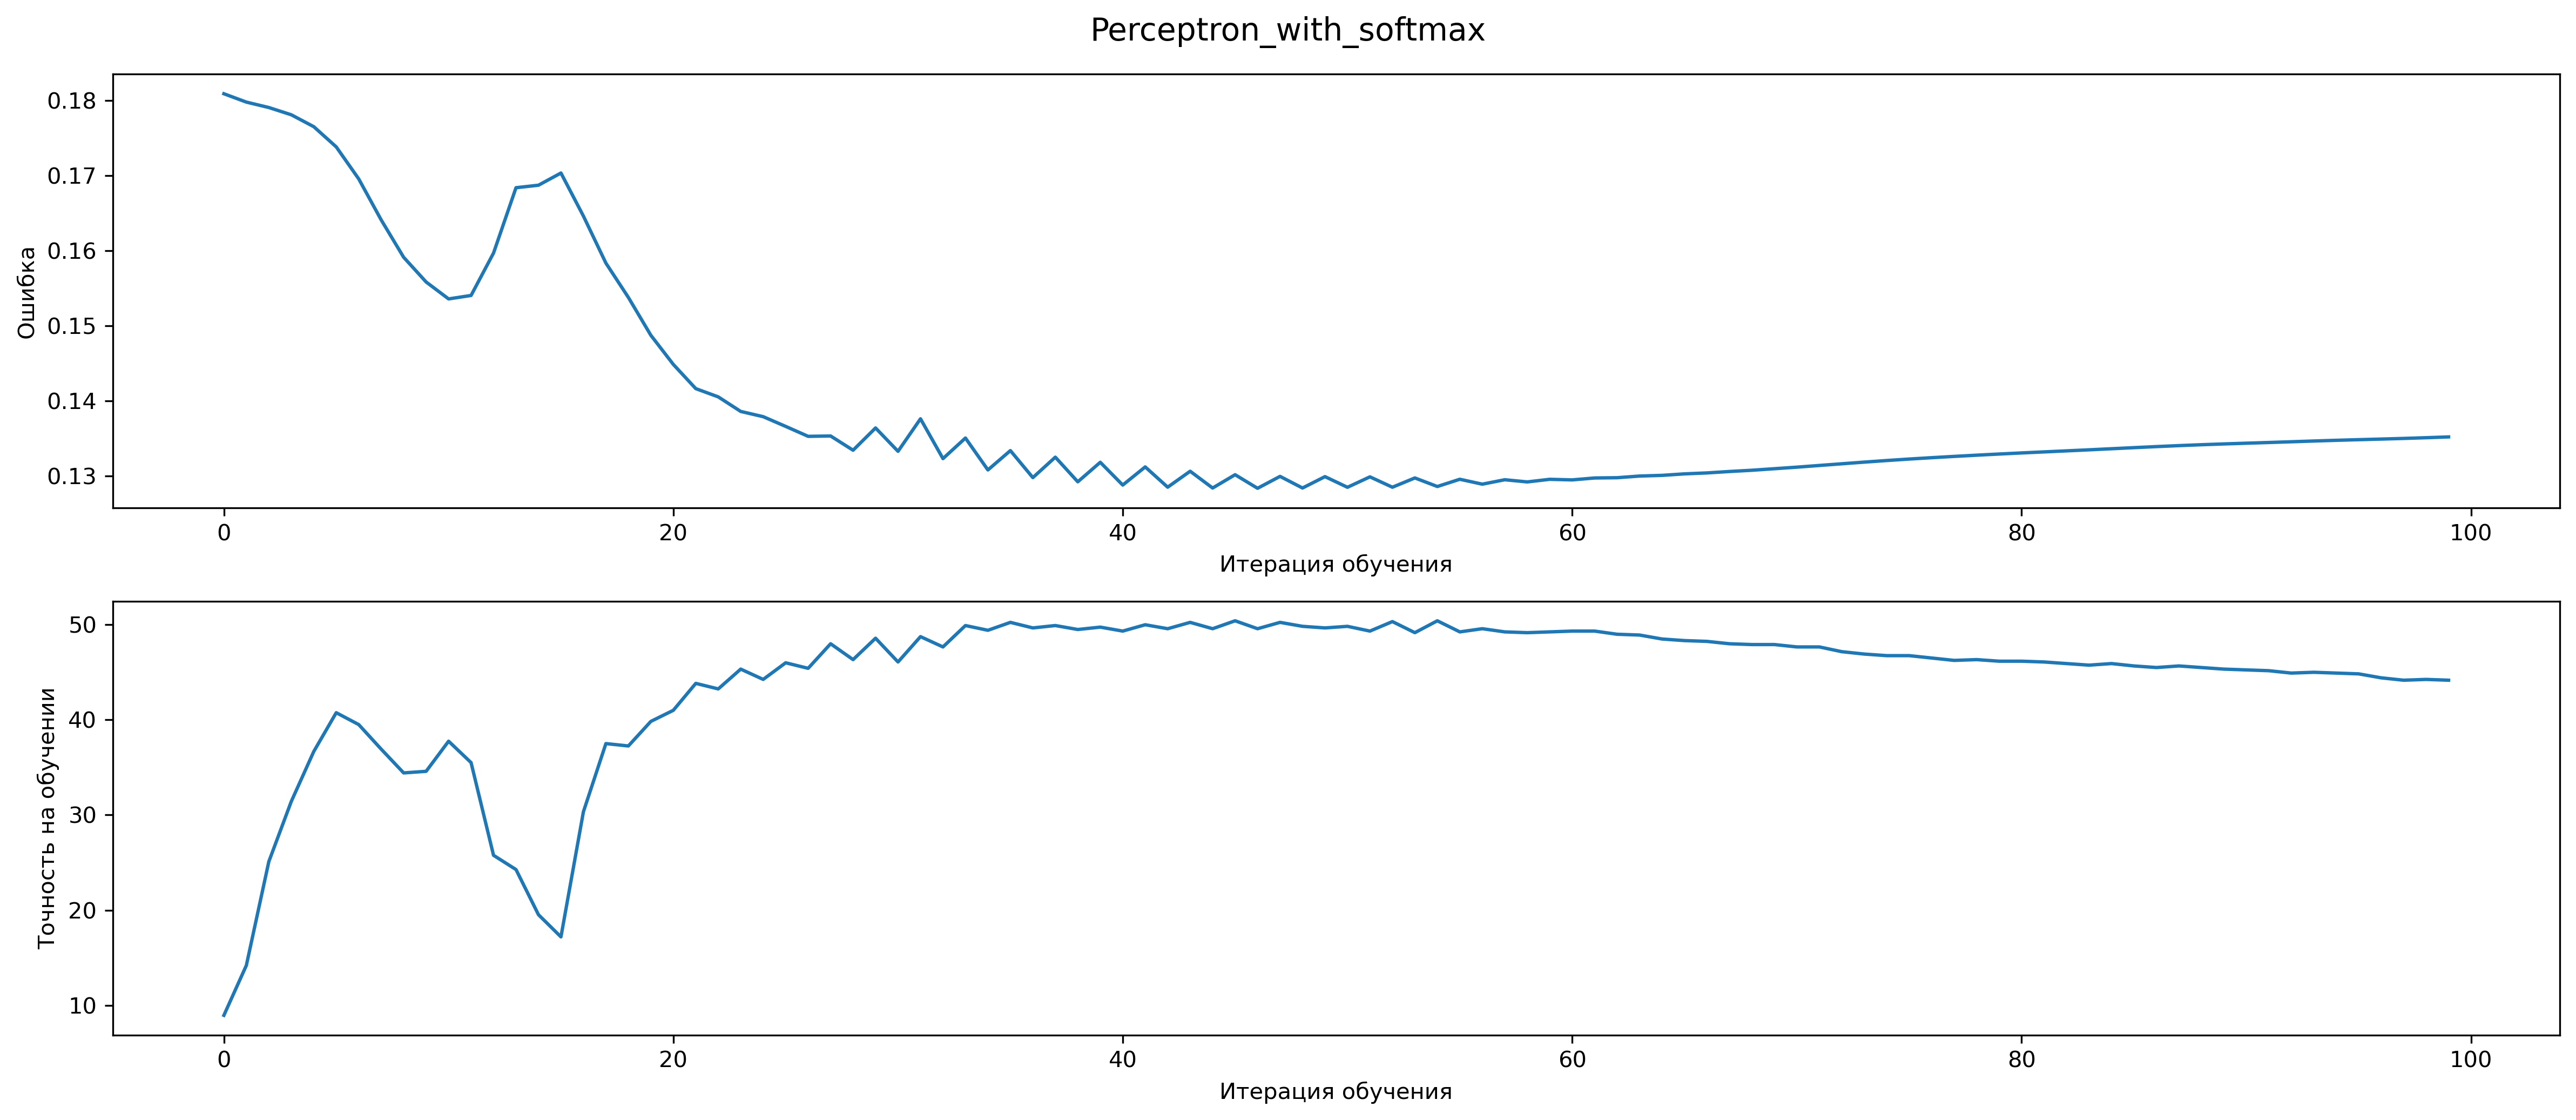

In [25]:
plot_errors_acc(params_nn['errors'], params_nn['accuracy_train'], 'Perceptron_with_softmax')

## 3.5 Добавляем второй скрытый слой

In [26]:
def nn_fit_2_hidden_layers(X, y, neuron_num_1=5, neuron_num_2=5, learning_rate=0.1, num_epochs=100):

    ''' Функция обучения нейронной сети, подсчета ошибки и точности обучения '''

    # случайная инициализация весов
    np.random.seed(1)
    w0 = np.random.random((64, neuron_num_1))
    w1 = np.random.random((neuron_num_1, neuron_num_2))
    w2 = np.random.random((neuron_num_2, 10))

    errors = []
    metrics = []

    # процесс обучения
    for _ in range(num_epochs):

        # прямое распространение(feed forward)
        layer0 = X                                # вход
        layer1 = sigmoid(np.dot(layer0, w0))      # промежуточный слой 1
        layer2 = sigmoid(np.dot(layer1, w1))      # промежуточный слой 1
        layer3 = sigmoid(np.dot(layer2, w2))      # выход

        # обратное распространение (back propagation)
        # с использованием градиентного спуска
        layer3_error = layer3 - y_train
        layer3_grad = layer3_error * sigmoid_deriv(layer3)

        layer2_error = layer3_grad.dot(w2.T)
        layer2_grad = layer2_error * sigmoid_deriv(layer2)

        layer1_error = layer2_grad.dot(w1.T)
        layer1_grad = layer1_error * sigmoid_deriv(layer1)

        w2 -= layer2.T.dot(layer3_grad) * learning_rate
        w1 -= layer1.T.dot(layer2_grad) * learning_rate
        w0 -= layer0.T.dot(layer1_grad) * learning_rate

        # ошибка модели
        error = np.mean(np.abs(layer3_error))
        errors.append(error)

        # метрики качества
        preds = np.argmax(layer3, axis=1)
        labels = np.argmax(y, axis=1)
        accuracy = (preds == labels).sum() * 100 / len(labels)
        metrics.append(accuracy)

    return {
        'weights': (w0, w1, w2),
        'errors': errors,
        'accuracy_train': metrics,
        'neuron_num': neuron_num_1 + neuron_num_2,
        'learning_rate': learning_rate,
        'num_epochs': num_epochs,
    }



In [27]:
params_nn = nn_fit_2_hidden_layers(X_train, y_train)
weights = params_nn['weights']
metrics = {}
metrics['train'] = params_nn['accuracy_train'][-1]
    
# тест
layer0_test = X_test
layer1_test = softmax(np.dot(layer0_test, weights[0]))
layer2_test = softmax(np.dot(layer1_test, weights[1]))
layer3_test = softmax(np.dot(layer2_test, weights[2]))

preds_test = np.argmax(layer3_test, axis=1)
labels_test = np.argmax(y_test, axis=1)
metrics['test'] = (preds_test == labels_test).sum() * 100 / len(labels_test)

    
stata = stata.append({
    'model_name': f'Perceptron_with_2_hidden_layers',
    'neuron_num': params_nn['neuron_num'],
    'learning_rate': params_nn['learning_rate'],
    'num_epochs': params_nn['num_epochs'],
    'accuracy_train': metrics['train'],
    'accuracy_test': metrics['test'],
}, ignore_index=True)

stata

,model_name,neuron_num,learning_rate,num_epochs,accuracy_train,accuracy_test
0,BaseLine,5,0.1000,100,47.630923,42.760943
1,Perceptron_with_10_hidden_neurons,10,0.1000,100,59.185370,56.228956
2,Perceptron_with_15_hidden_neurons,15,0.1000,100,70.822943,71.380471
3,Perceptron_with_30_hidden_neurons,30,0.1000,100,89.027431,85.521886
4,Perceptron_with_50_hidden_neurons,50,0.1000,100,84.039900,80.134680
5,Perceptron_with_60_hidden_neurons,60,0.1000,100,81.296758,82.154882
6,Perceptron_with_75_hidden_neurons,75,0.1000,100,86.783042,86.868687
7,Perceptron_with_90_hidden_neurons,90,0.1000,100,83.956775,82.154882
8,Perceptron_with_100_hidden_neurons,100,0.1000,100,78.221114,75.589226
9,Perceptron_with_1_learning_rate,5,1.0000,100,30.673317,13.468013


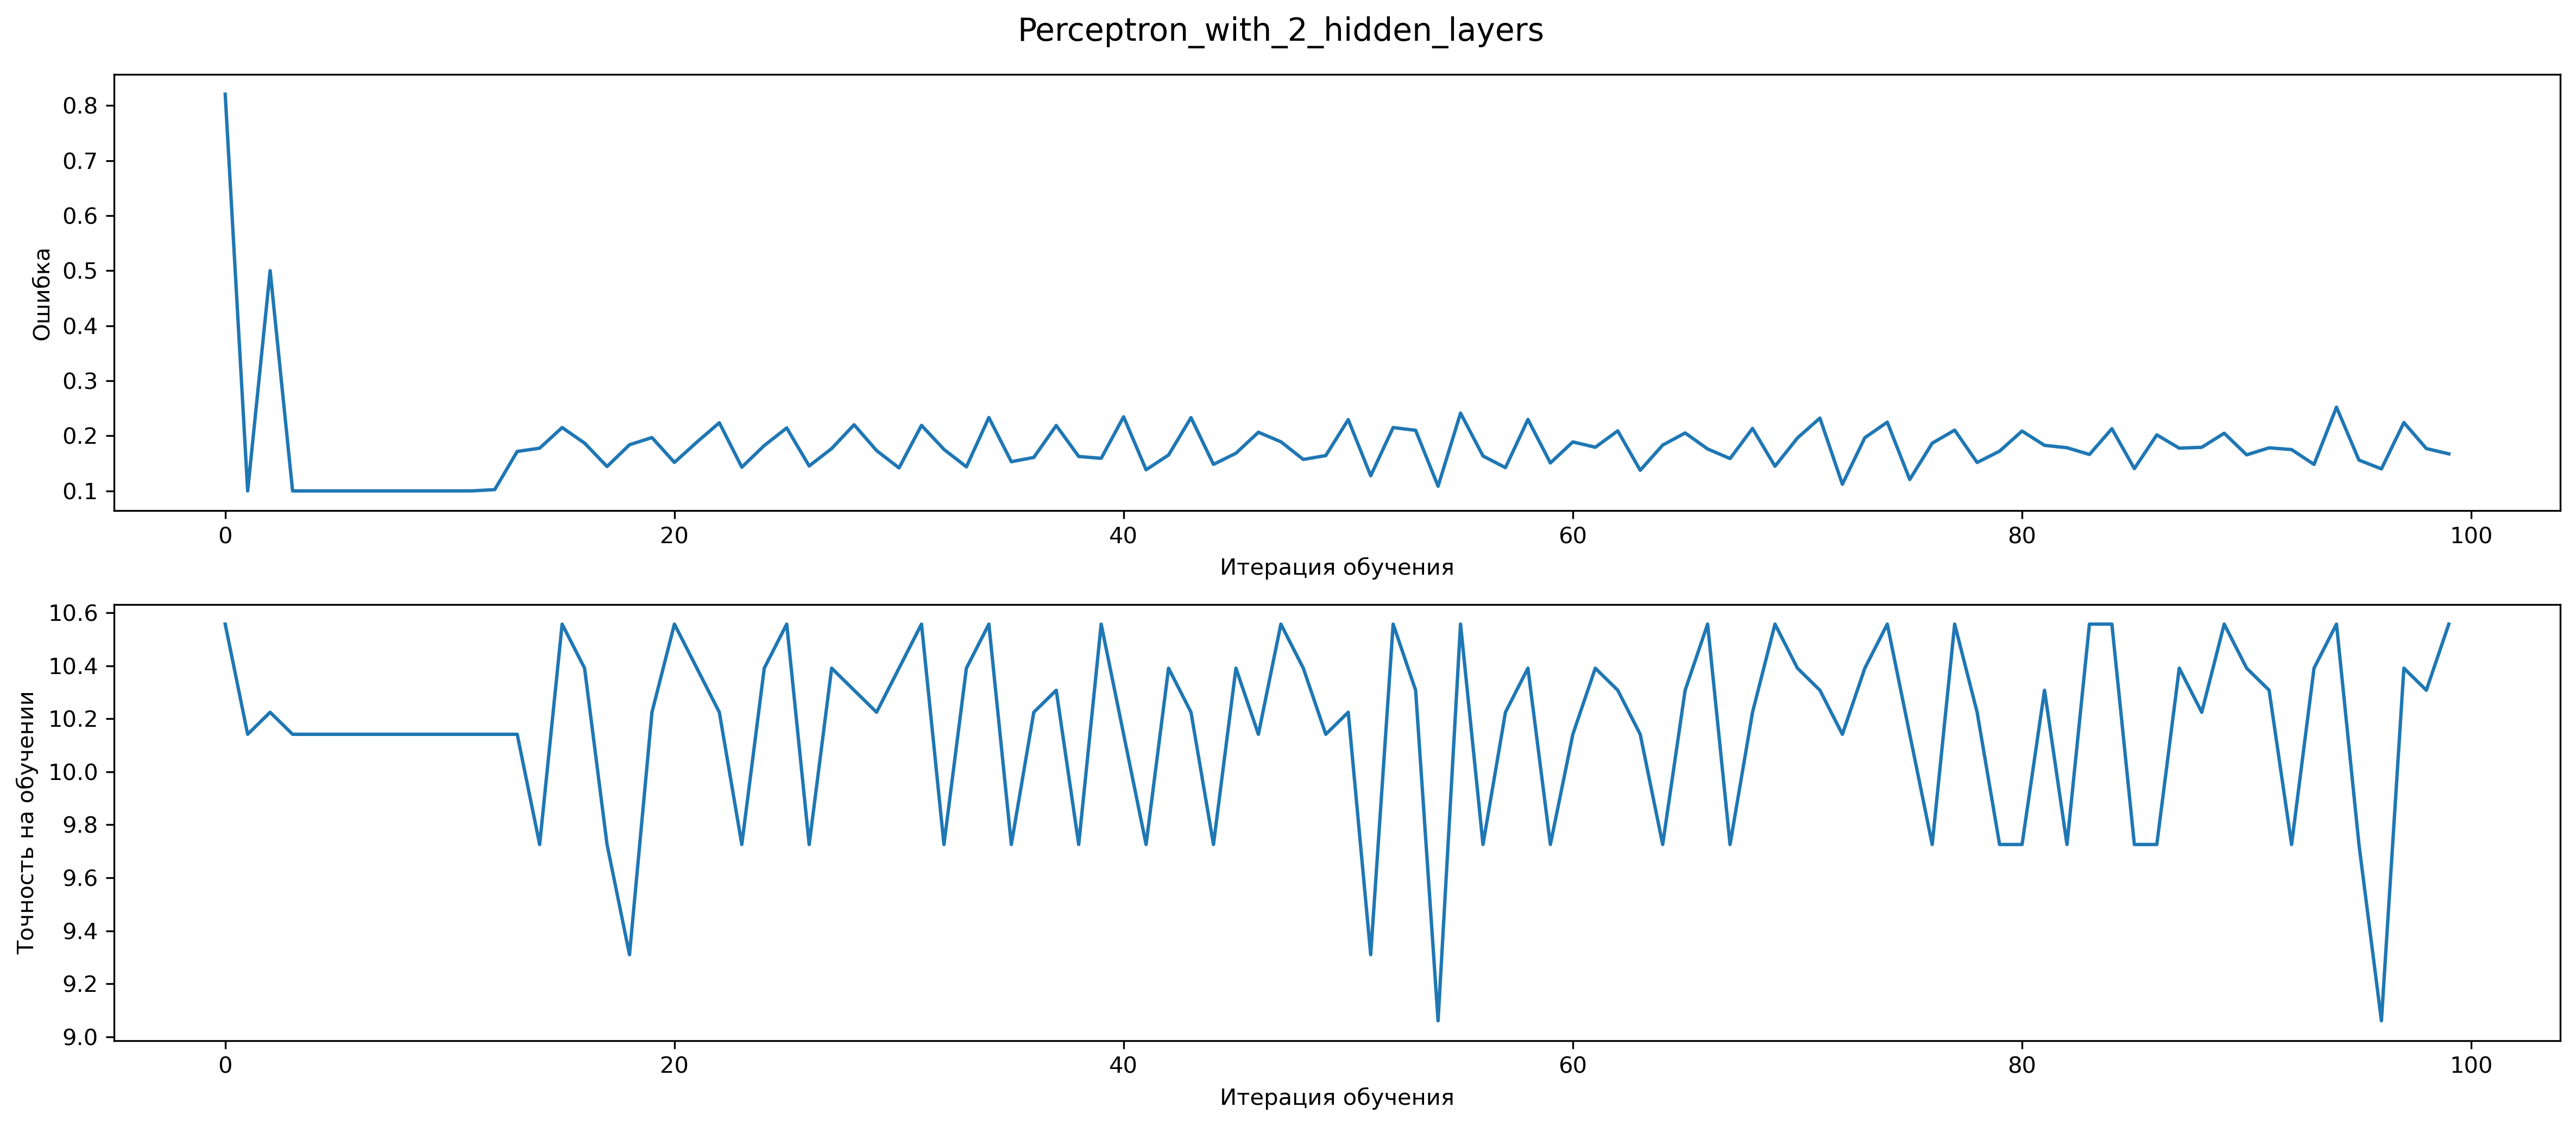

In [30]:
plot_errors_acc(params_nn['errors'], params_nn['accuracy_train'], "Perceptron_with_2_hidden_layers")

# 4. Выводы

In [29]:
stata.sort_values(by='accuracy_test', ascending=False, inplace=True)
stata

,model_name,neuron_num,learning_rate,num_epochs,accuracy_train,accuracy_test
6,Perceptron_with_75_hidden_neurons,75,0.1000,100,86.783042,86.868687
3,Perceptron_with_30_hidden_neurons,30,0.1000,100,89.027431,85.521886
5,Perceptron_with_60_hidden_neurons,60,0.1000,100,81.296758,82.154882
7,Perceptron_with_90_hidden_neurons,90,0.1000,100,83.956775,82.154882
4,Perceptron_with_50_hidden_neurons,50,0.1000,100,84.039900,80.134680
8,Perceptron_with_100_hidden_neurons,100,0.1000,100,78.221114,75.589226
2,Perceptron_with_15_hidden_neurons,15,0.1000,100,70.822943,71.380471
1,Perceptron_with_10_hidden_neurons,10,0.1000,100,59.185370,56.228956
20,Perceptron_with_dynamic_learning_rate,5,0.1000,100,46.051538,47.643098
16,Perceptron_with_0.01_learning_rate,5,0.0100,100,49.459684,46.801347


* в основном на увеличение точности модели ИНС повлияло увеличение количества нейронов скрытого слоя 
* это увеличение не бесконечно, оптимальное количество из всех проверенных - 75
* изменение шага обучения практически не способствует улучшению качества модели
* изменение функции активации на `soft_max` немного способствовало увеличению точности модели ИНС
* добавление ещё одного скрытого слоя ухудшило точность модели ИНС